## Imports

In [1]:
import ast
import pandas as pd
import numpy as np
import os
from os.path import abspath, join
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
from matplotlib.figure import Figure
import pickle

from nipype.interfaces import fsl
from nipype.testing import example_data

from nilearn import image, plotting
from nilearn.image import get_data
from nilearn.image import load_img, math_img

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use("ggplot")

## Folder structure


In [2]:
experiment_dir = '/data/tu_aljedawi/DLT/'

participants = ['P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039',
                'P054', 'P055', 'P056', 'P057', 'P059', 'P061', 'P062', 'P063', 'P064',
                'P065', 'P066', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076']

if not os.path.exists(experiment_dir + "data/mri/functionalspace"):
    os.makedirs(experiment_dir + "data/mri/functionalspace") 
output_dir = experiment_dir + "data/mri/functionalspace/"

if not os.path.exists(output_dir + "python_objects"):
    os.makedirs(output_dir + "python_objects")
po_dir = output_dir + "python_objects/"

# Freesurfer ROIs directory
rois_fs = ["hpc", "ec"]
for i_roi in rois_fs:
    if not os.path.exists(output_dir + "%s_lr" % i_roi):
        os.makedirs(output_dir + "%s_lr" % i_roi)

# MNI ROIs directory
rois_mni = ["aHPC", "alEC"]
for i_roi in rois_mni:
    if not os.path.exists(output_dir + "mni/%s_lr" % i_roi):
        os.makedirs(output_dir + "mni/%s_lr" % i_roi)
    
    # intersected masks directory
    if not os.path.exists(output_dir + "intersected_masks/%s_lr" % i_roi):
        os.makedirs(output_dir + "intersected_masks/%s_lr" % i_roi)
    
    # timeseries directory
    if not os.path.exists(output_dir + "timeseries/%s_lr" % i_roi):
        os.makedirs(output_dir + "timeseries/%s_lr" % i_roi)
        
    # correlation matrices directory
    if not os.path.exists(output_dir + "correlation_matrices/%s_lr" % i_roi):
        os.makedirs(output_dir + "correlation_matrices/%s_lr" % i_roi)

# Loading the Data Sets

# Temporal Logs
Load the temporal logs data from the relevant text files into a dictionary with the participant's number as the dictionary `key` and a dataframe of the participant's logs data as its `value`. Following this format: `logs = {'P0XX' : DataFrame[...]}`

In [3]:
logs_dir = experiment_dir + "data/behavior/logs/day_learning/"

logs = {}
for filename in os.listdir(logs_dir):
    if filename.endswith(".txt") and filename.startswith(tuple(participants)):
        key = filename.split('-')[0]
        data = pd.read_csv(os.path.join(logs_dir,filename), sep="\t", header=None)
        data.columns =['fc_on', 'fc_off', 'cue_start', 'cue_id', 'blkscrn_on', 'volume',
                       'repetition', 'real_time', 'virtual_day', 'trial_endtime']
        logs[key] = data
        
    else:
        continue

logs.items()

dict_items([('P062',        fc_on   fc_off  cue_start  cue_id  blkscrn_on  volume  repetition  \
0      14733    18766      18767    6.58       20282       9           1   
1      20282    21016      21039   10.00       22539      10           1   
2      22539    23315      23316    8.03       24832      11           1   
3      24832    30382      30405    1.00       31915      15           1   
4      31915    34081      34082   10.38       35598      16           1   
..       ...      ...        ...     ...         ...     ...         ...   
303  2398472  2404238    2404238   15.55     2405755    1060           7   
304  2405755  2406321    2406345   19.00     2407855    1061           7   
305  2407855  2409354    2409355   16.44     2410871    1063           7   
306  2410871  2418820    2418845   16.00     2420354    1067           7   
307  2420354  2426087    2426087   19.25     2427603    1070           7   

     real_time  virtual_day  trial_endtime  
0       4.0207       

In [4]:
logs['P064'].head(12)

,fc_on,fc_off,cue_start,cue_id,blkscrn_on,volume,repetition,real_time,virtual_day,trial_endtime
0,20793,24266,24266,8.33,25782,12,1,3.4649,2,25782
1,25782,30182,30204,13.00,31705,14,1,9.3750,2,31705
2,31705,33715,33716,10.04,35232,16,1,12.9010,2,35232
3,35232,39565,39587,18.00,41098,19,1,18.7500,2,41098
4,41098,51014,51015,12.50,52531,24,1,30.2088,2,52531
5,52531,56764,56786,20.00,58297,26,1,35.9375,2,58297
6,58297,61463,61464,14.30,62980,28,1,40.6609,2,62980
7,62980,75496,75518,14.00,77029,34,1,54.6875,2,77029
8,77029,87195,87196,18.37,88712,40,1,66.3793,2,88712
9,88712,91128,91151,19.00,92661,41,1,70.3125,2,92662


# Regions of Interest

We want to combine masks from the individual Freesurfer segmentations of the HPC and EC with masks dividing the subregions of the HPC and EC.

The participants' Freesurfer masks are saved in /data/mri/rois/hpc_lr/freesurfer_highres_space, and the standard MNI masks are saved in /data/mri/rois/mni_masks. All masks will be co-registered to the analysis space, which is the space of the functional images. This relies on the FSL transformation matrices and warp files stored in the /data/mri/processed for each participant.

**1. Apply flirt**   
To co-register both Freesurfer and standard MNI masks to the functional space.


**2. Binarize the outputs**   
Before intersecting the resulting ROIs from previous steps, we first need to binarize the masked ROIs using a threshold. We chose this threshold to be 0.5 in this case. This step is required because the previous co-registeration steps resulted in matrices of type float due to the mathmatical transformations that were applied on the masks.  

**3. Intersect the binarized output masks**  

In [5]:
def flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat):
    flt = fsl.FLIRT(apply_xfm=True, verbose=0)
    flt.inputs.in_file = input_dir
    flt.inputs.reference = ref_dir
    flt.inputs.in_matrix_file = mat_dir
    flt.inputs.out_file = out_file
    flt.inputs.out_matrix_file = out_mat
    #print(flt.cmdline)
    result = flt.run()
    return result

## Coregister Freesurfer masks to functional space

In [6]:
# threshold for binarizing the output masks
threshold = 0.5

rois_fs = ["hpc", "ec"]

for i_roi in rois_fs:
    #print(i_roi)
    working_dir = join(output_dir,"%s_lr/" %(i_roi))
    i=0
    
    for p in participants:
        i+=1
        input_dir = join(experiment_dir, "data/mri/rois/%s_lr/freesurfer_highres_space/%s_%s_lr_fs_hs.nii.gz" % (i_roi,p,i_roi))
        #print(str(i) + input_dir)
        ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
        #print(str(i) + ref_dir)
        mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/highres2example_func.mat" % p)
        #print(str(i) + mat_dir)
        out_file = join(working_dir, "%s_%s_fs.nii.gz" % (p,i_roi))
        #print(str(i) + out_file)
        out_mat = join(working_dir, "%s_%s_fs_hs_flirt.mat" % (p,i_roi))
        #print(str(i) + out_mat)
        res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
        #print(res.outputs)
        
        # use math_img to binarize the masked ROIs using a threshold of 0.5
        binary_mask = math_img(f'img > {threshold}', img=out_file)
        binary_mask.to_filename(join(working_dir, "%s_%s_fs_binary.nii.gz" % (p,i_roi)))

## Atlas masks

In [7]:
rois_mni = ["aHPC", "alEC"]

for i_roi in rois_mni:
    #print(i_roi)
    working_dir = join(output_dir,"mni/%s_lr/" %(i_roi))
    i=0
    
    for p in participants:
        i+=1
        input_dir = join(experiment_dir, "data/mri/rois/mni_masks/%s_lr.nii.gz" % (i_roi))
        #print(str(i) + input_dir)
        ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
        #print(str(i) + ref_dir)
        mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/standard2example_func.mat" % p)
        #print(str(i) + mat_dir)
        out_file = join(working_dir, "%s_%s_mni.nii.gz" % (p,i_roi))
        #print(str(i) + out_file)
        out_mat = join(working_dir, "%s_%s_mni_flirt.mat" % (p,i_roi))
        #print(str(i) + out_mat)
        res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
        #print(res.outputs)
        
        # use math_im to binarize the masked ROIs using a threshold of 0.5
        binary_mask = math_img(f'img > {threshold}', img=out_file)
        binary_mask.to_filename(join(working_dir, "%s_%s_mni_binary.nii.gz" % (p,i_roi)))

## Intersecting the masks
In the last step, we intersect the masks from Freesurfer with the respective subregion masks. At this point, both masks are in the functional analysis space and have been binarized. Finally, we generate a PDF of diagnostic plots to check the final ROI masks.

In [6]:
%%time

rois_mni = ["aHPC", "alEC"]
rois_fs = {"aHPC":"hpc", "alEC":"ec"}

roi_imgs = []
titles = []
bg_imgs = []

imasks = {}
imasks = {"aHPC":{p:0 for p in participants},
         "alEC":{p:0 for p in participants}}

for i_roi in rois_mni:
    working_dir = join(output_dir,"intersected_masks/%s_lr/" %(i_roi))
    #print(working_dir)
    f_roi = rois_fs[i_roi]
    
    for p in participants:
        fs = load_img(join(output_dir, "%s_lr/%s_%s_fs_binary.nii.gz" %(f_roi,p,f_roi)))
        mn = load_img(join(output_dir, "mni/%s_lr/%s_%s_mni_binary.nii.gz" %(i_roi,p,i_roi)))
        intersec_mask = math_img('img1 * img2', img1=fs, img2=mn)
        intersec_mask.to_filename(join(working_dir, "%s_%s.nii.gz" %(p,i_roi)))
        #print("out_file =", join(working_dir,"%s_%s.nii.gz" %(p,i_roi)))
        imasks[i_roi][p] = intersec_mask
        
        # saving the outputs to generate a PDF of diagnostic plots of the final ROI masks
        roi_img = join(working_dir,"%s_%s.nii.gz" %(p,i_roi))
        bg_img = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mean_func.nii.gz" %p)
        t = ("%s_%s" %(p,i_roi))
        roi_imgs.append(roi_img)
        bg_imgs.append(bg_img)
        titles.append(t)

with open(join(po_dir, "intersected_masks_all.pickle"),"wb") as f:
    pickle.dump(imasks, f)

print("Finished interesecting a total of %d ROI masks" % len(roi_imgs))

Finished interesecting a total of 54 ROI masks
CPU times: user 14.9 s, sys: 718 ms, total: 15.6 s
Wall time: 16.7 s


### PDF of diagnostic plots generation

In [7]:
%%time

# Plot multiple figures into a single PDF with matplotlib, using the object-oriented interface
plts = zip(roi_imgs, titles, bg_imgs)

def pdf_diagnostics():
    with PdfPages(join(output_dir,"intersected_masks/ROIs_ALL.pdf")) as pages:
        for pl in plts:
            fig = Figure()
            ax = fig.gca()
            plotting.plot_roi(pl[0],title=pl[1], display_mode='ortho', annotate=False, draw_cross=False,
                              cmap="cool", black_bg=True, bg_img=pl[2], axes=ax)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)

    print("PDF of diagnostic plots of the final ROI masks is generated in:\n",
          join(output_dir,"intersected_masks/ROIs_ALL.pdf"))

#pdf_diagnostics()

CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 25.5 µs


In [8]:
# find the coordinates 
# display = plotting.plot_roi(pl[0],title=pl[1], display_mode='ortho', annotate=False, draw_cross=False,
#                             cmap="cool", black_bg=True, bg_img=pl[2])

# Get multi-voxel patterns from ROIs

In [9]:
def fsl_info(arr):
    # Printing type of arr object
    print("Array is of type: ", type(arr))
    # Printing array dimensions (axes)
    print("No. of dimensions: ", arr.ndim)
    # Printing shape of array
    print("Shape of array: ", arr.shape)
    # Printing size (total number of elements) of array
    print("Size of array: ", arr.size)
    # Printing type of elements in array
    print("Array stores elements of type: ", arr.dtype)

## Extract ROI time series

 0. Load all filtered_func, masks matrices
 1. a = Reduce my intersected mask matrix to 1D vector
 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
 4. Output is: P064_aHPC_timeseries, save them as csv or pickle

In [10]:
%%time
RELOAD_DATA = False

# Load the functional data (filtered_func NIFTIs) for all participants and pickle it out as a Python object
def load_filteredfunc_data():
    filtered_func_all = {}
    filtered_func_all = {p:0 for p in participants}

    for p in participants:
        ffunc_nii = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/filtered_func_data.nii.gz" %p)
        ffunc_data = get_data(ffunc_nii)
        filtered_func_all[p] = ffunc_data
    
    with open(join(po_dir, "filtered_func_all.pickle"),"wb") as f:
        pickle.dump(filtered_func_all, f)
    return filtered_func_all
        


if not os.path.exists(join(po_dir, "filtered_func_all.pickle")) or RELOAD_DATA:
    print("Loading functional data for the first time (approx. 35 min)")
    filtered_func_all = load_filteredfunc_data()
    
else:
    print("Loading saved functional data (approx. 7 min)")
    with open(join(output_dir, "python_objects/filtered_func_all.pickle"),"rb") as f:
        filtered_func_all = pickle.load(f)

dict(list(filtered_func_all.items())[0:2])

Loading saved functional data (approx. 7 min)
CPU times: user 1min 2s, sys: 4min 1s, total: 5min 4s
Wall time: 5min 12s


{'P031': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
     

In [11]:
%%time

rois_mni = ["aHPC", "alEC"]

def create_fmri_timeseries():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"timeseries/%s_lr/" %(i_roi))

        for p in participants:        
            a = get_data(imasks[i_roi][p])
            b = filtered_func_all[p]

            # 1. a = Reduce my intersected mask matrix to 1D vector
            a_re = np.reshape(a, a.size)

            # 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
            b_re = np.reshape(b, (b.shape[0]*b.shape[1]*b.shape[2], b.shape[-1]))

            # 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
            b_timeseries = b_re[(a_re == 1),:]

            # 4. Output example is: P064_aHPC_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_timeseries.csv" % (p,i_roi)), b_timeseries, delimiter=",")


# TODO: run this line onlyif RELOAD is ON and timerseries_dir (and subdirs) is empty            
# Wall time: 34min 34s
#create_fmri_timeseries()

CPU times: user 4 µs, sys: 10 µs, total: 14 µs
Wall time: 20.3 µs


In [12]:
%%time

# test output of create_fmri_timeseries for one participant
p_test = "P064"
i_roi_test = "aHPC"

a_test = get_data(imasks[i_roi_test][p_test])
b_test = filtered_func_all[p_test]

# 1. a = Reduce my intersected mask matrix to 1D vector
a_re_test = np.reshape(a_test, a_test.size)

# 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
b_re_test = np.reshape(b_test, (b_test.shape[0]*b_test.shape[1]*b_test.shape[2], b_test.shape[-1]))

# 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
b_timeseries_test = b_re_test[(a_re_test == 1),:]

print("For participant "+ p_test + " (" + i_roi_test + "):")
print("1) a.shape:", a_test.shape)
print("1) a_reduced.shape:", a_re_test.shape)
print("\n2) b.shape:", b_test.shape)
print("2) b_reduced.shape:", b_re_test.shape)
print("\n3) b_timeseries.shape:", b_timeseries_test.shape)

For participant P064 (aHPC):
1) a.shape: (140, 140, 40)
1) a_reduced.shape: (784000,)

2) b.shape: (140, 140, 40, 1078)
2) b_reduced.shape: (784000, 1078)

3) b_timeseries.shape: (751, 1078)
CPU times: user 44.5 s, sys: 15.3 s, total: 59.8 s
Wall time: 1min


## Calculate residuals from motion parameter regression
The purpose of this step is to remove the chuncks from my ROI timeseries that can be explained by motion.

 1. Build a linear model to predict voxels time series using MC parameters
 2. Visualize your timeseries against your model prediction
 3. Take my residuals as the cleaned up data 
 4. Output is: P064_aHPC_timeseries_cleaned, save it as csv

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [128]:
# load the ROI timeseries (combined mask)
def read_timeseries(participant, roi):
    file = join(output_dir,"timeseries/%s_lr/%s_%s_timeseries.csv" % (roi,participant,roi))
    df = pd.read_csv(file, header=None)
    return df

print(p)
print(i_roi)
roi_dat = read_timeseries(p, i_roi)
print(roi_dat.shape)
roi_dat.head()

P064
aHPC
(751, 1078)


,0,1,2,3,4,5,6,7,8,9,...,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077
0,9408.536133,9406.659180,7652.909180,11291.045898,7570.811523,8919.093750,9372.638672,7528.651367,8962.213867,9485.249023,...,9519.594727,7710.777832,10211.394531,8855.358398,8906.527344,7702.159180,9841.141602,9716.019531,7540.690430,8940.338867
1,10344.272461,7730.428223,9806.166016,7992.320312,8370.613281,8708.423828,8297.311523,9142.193359,7007.068848,9835.951172,...,9296.463867,6899.264648,10182.304688,5866.788086,8430.468750,8773.650391,8036.244141,9285.343750,8059.120117,9902.461914
2,8558.516602,9780.839844,8558.451172,8643.367188,9549.396484,7543.099609,8315.195312,7529.490234,9175.364258,10058.496094,...,9496.666016,8789.453125,9040.513672,8089.039062,8203.117188,9114.593750,9241.185547,8081.089844,8935.445312,9884.926758
3,9967.173828,8171.140625,5890.091309,9141.611328,8538.002930,6962.477539,9543.565430,6233.931152,6865.820312,6899.190430,...,7636.838379,8145.987305,10490.041016,9411.022461,6897.286621,7886.453125,7575.062500,8217.898438,6272.078125,6838.618652
4,8805.032227,6653.545898,8230.936523,7249.413086,8452.761719,9228.687500,6461.213379,6898.583984,5410.257324,5229.260742,...,7795.376953,7028.146484,8532.314453,5693.026855,6378.200195,7352.200684,6458.626953,7166.008301,7637.050781,8157.905273


In [167]:
%%time

rois_mni = ['aHPC', 'alEC']

def run_motion_glm():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"timeseries/%s_lr/" %(i_roi))

        for p in participants:
            # load the motion params and convert to a pandas dataframe
            mc_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mc/prefiltered_func_data_mcf_final.par"%p)
            mp_df = pd.read_csv(mc_dir, header=None, delimiter=r"\s+")
            mp_df.columns = ["mp" + str(num) for num in range(1,7)]

            # load the ROI timeseries (combined mask)
            roi_dat = read_timeseries(p, i_roi)
            roi_dat = roi_dat.loc[(roi_dat!=0).any(axis=1)] # remove rows with all 0s 

            roi_dat_clean = np.zeros(roi_dat.shape)

            for i_vox in range(roi_dat.shape[0]):
                #print(i_vox)
                # extract this voxel's data and merge with motion params
                vox_dat = roi_dat.iloc[i_vox,]
                vox_df = vox_dat.to_frame()
                vox_df.columns = ["vox_dat"]
                #print(vox_df.shape)
                #print(mp_df.shape)
                vox_df = pd.concat([vox_df, mp_df], axis=1)

                # linear model
                model = smf.glm(formula = 'vox_dat~mp1+mp2+mp3+mp4+mp5+mp6', data=vox_df)
                result = model.fit()
                #print(result.summary())
                roi_dat_clean[i_vox,] = result.resid_response

            # Output example is: P064_aHPC_clean_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_clean_timeseries.csv" % (p,i_roi)), roi_dat_clean, delimiter=",")

# (approx. 40 min)
#run_motion_glm()

CPU times: user 1h 40min 13s, sys: 18min 34s, total: 1h 58min 47s
Wall time: 40min 21s


In [19]:
# load the ROI timeseries (combined mask)
def read_cltimeseries(participant, roi, dataframe=False):
    file = join(output_dir,"timeseries/%s_lr/%s_%s_clean_timeseries.csv" % (roi,participant,roi))
    return np.genfromtxt(file, delimiter=',')

# Inter-voxel similarity

1. extract virtual days voxel matrices
2. create voxel-by-voxel corr. matrices

In [24]:
virtual_days = range(1,5)
repetitions = range(1,8)
read_cltimeseries(p, i_roi).shape[0]

274

In [28]:
%%time
RELOAD_DATA = False

def extract_virtualdays_data():
    vdays_dat = {}
    vdays_dat = {"aHPC":{p:{v:{rep:0 for rep in repetitions} for v in virtual_days} for p in participants},
                 "alEC":{p:{v:{rep:0 for rep in repetitions} for v in virtual_days} for p in participants}}

    for i_roi in rois_mni:
        print("Current ROI: ", i_roi)
        working_dir = join(output_dir,"timeseries/%s_lr/" %(i_roi))

        for p in participants:
            #print(p)
            roi_dat_clean = read_cltimeseries(p, i_roi)
            i = roi_dat_clean.shape[0]
            for vd in virtual_days:
                #print(vd)
                for rep in repetitions:
                    #print(rep)
                    start_vol = int((logs[p][(logs[p].virtual_day==vd) & (logs[p].block==rep)].volume).head(1))
                    end_vol = int(((logs[p][(logs[p].virtual_day==vd) & (logs[p].block==rep)].volume)).tail(1))
                    j = end_vol - start_vol
                    vox_vol = np.zeros(i*j).reshape(i,j)
                    #print(vox_vol.shape)
                    vdays_dat[i_roi][p][vd][rep] = roi_dat_clean[:,start_vol+2:end_vol+2]

    with open(join(po_dir, "virtualdays_dat_all.pickle"),"wb") as f:
        pickle.dump(vdays_dat, f)

    return vdays_dat


if not os.path.exists(join(po_dir, "virtualdays_dat_all.pickle")) or RELOAD_DATA:
    print("Extracting virtual days data...")
    vdays_dat = extract_virtualdays_data()
    
else:
    print("Loading already extracted virtual days data...")
    with open(join(po_dir, "virtualdays_dat_all.pickle"),"rb") as f:
        vdays_dat = pickle.load(f)

dict(list(vdays_dat.items())[0:1])

Loading already extracted virtual days data...
CPU times: user 107 ms, sys: 221 ms, total: 328 ms
Wall time: 330 ms


{'aHPC': {'P031': {1: {1: array([[  399.33698504,   340.8104022 ,  -773.89644454, ...,
             -344.8653735 ,  -617.91162559,  1038.78838828],
           [ -908.69299994,  -244.94603995,   938.4048016 , ...,
             -363.34210548,  -156.86269917,  -739.59347291],
           [ -265.41091572,  -784.13193852,   -86.68755455, ...,
              269.89700116,   814.9229772 ,   761.08204049],
           ...,
           [ -275.77259928,  -421.42078116,   825.92542404, ...,
             -687.85748588,  -726.90325314, -1166.18483508],
           [ -142.45164738,   669.31992252,  -943.02815659, ...,
              921.58366787,   717.9977102 ,  -990.92256833],
           [ 1097.45191477,    -6.16915711,   507.92478596, ...,
             -611.96079135,   403.29938261,  1053.32863964]]),
    2: array([[  -12.86182276,  -101.60592941,   121.30679882, ...,
             -431.54976945, -1350.77230903,  -657.4364956 ],
           [  367.36051877,   132.6624347 ,    79.61813554, ...,
          

## Voxel-by-voxel correlation matrices
Every **trial** consists of a virtual day and a repetition. Thus, for a given ROI and a given participant, we have a total of 28 trials (four virtual days and seven repetition per day).
<pre><code>
for each ROI:   
    for each participant:     
        for each virtual day:     
            for each repetition of that virtual day: 
             - I have a voxel-by-time courses matrix B.
             - I want to create a voxel-by-voxel correlation matrix of matrix B. In other words, I take
             every row (voxel) of matrix B and correlate it with every row in that matrix. The result is
             a new matrix of correlation coefficients for every voxel with other voxel.
</code></pre>

In [109]:
%%time

def create_voxel_by_voxel_corr():
    for i_roi in rois_mni:
        print("Current ROI:", i_roi)
        working_dir = join(output_dir,"correlation_matrices/%s_lr/" %(i_roi))

        for p in participants:
            #print("Participant:", p)
            i=0

            for vd in virtual_days:
                #print("Virtual Day:", vd)

                for rep in vdays_dat[i_roi][p][d].keys():
                    #print(rep)
                    voxels = vdays_dat[i_roi][p][vd][rep]
                    #print(voxels.shape)

                    # we need to transpose the matrix because pandas.DF.corr() computes correlation of columns
                    voxels_transposed = np.transpose(voxels)
                    #print(voxels_transposed.shape)
                    df_corr = pd.DataFrame(voxels_transposed).corr()
                    #print(df_corr.shape)
                    df_corr.to_csv(join(working_dir,"%s_%s_vDay%s_rep%s_voxelbyvoxel_corr.csv" %(p,i_roi,vd,rep)),
                                   index=False, header=False)
                    i+=1
            print("Created %s %s correlation matrices for participant %s" %(str(i),df_corr.shape,p))

# (approx. 31 min)
#create_voxel_by_voxel_corr()

Current ROI: aHPC
Created 28 (886, 886) correlation matrices for participant P031
Created 28 (868, 868) correlation matrices for participant P032
Created 28 (580, 580) correlation matrices for participant P033
Created 28 (858, 858) correlation matrices for participant P034
Created 28 (706, 706) correlation matrices for participant P035
Created 28 (660, 660) correlation matrices for participant P036
Created 28 (765, 765) correlation matrices for participant P037
Created 28 (795, 795) correlation matrices for participant P038
Created 28 (880, 880) correlation matrices for participant P039
Created 28 (866, 866) correlation matrices for participant P054
Created 28 (807, 807) correlation matrices for participant P055
Created 28 (937, 937) correlation matrices for participant P056
Created 28 (827, 827) correlation matrices for participant P057
Created 28 (838, 838) correlation matrices for participant P059
Created 28 (851, 851) correlation matrices for participant P061
Created 28 (833, 833) 

### Visualize correlation matrices

In [126]:
def read_corr_mat(p, roi, vday, rep):
    df = pd.read_csv(join(output_dir,
                          "correlation_matrices/%s_lr/%s_%s_vDay%s_rep%s_voxelbyvoxel_corr.csv" %(roi,p,roi,vday,rep)),
                     header=None)
    return df

df = read_corr_mat("P034","alEC",3,3)
print(df.shape)
df.head()

(54, 54)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,1.000000,0.301915,-0.320984,-0.167338,0.009379,0.305622,-0.050073,0.242308,-0.054766,-0.366538,...,0.185879,0.138127,-0.305191,0.028473,0.241020,0.083264,0.272819,-0.218476,-0.033698,-0.047909
1,0.301915,1.000000,0.191720,-0.046885,-0.202090,0.132599,0.091070,0.138643,0.276295,0.088106,...,0.160601,0.172948,0.001497,0.175230,-0.220776,-0.287284,-0.211974,0.156273,0.251359,-0.024000
2,-0.320984,0.191720,1.000000,0.317619,0.325022,-0.054299,0.136250,-0.068185,-0.101411,0.235461,...,-0.250586,-0.002285,0.008706,0.142181,-0.358344,-0.035276,-0.009993,0.232709,-0.097569,-0.293469
3,-0.167338,-0.046885,0.317619,1.000000,0.132519,-0.140120,0.142594,-0.195913,-0.369976,0.092300,...,0.098771,-0.025562,-0.179689,0.018687,0.010094,0.242940,0.131480,0.088728,0.062484,0.035371
4,0.009379,-0.202090,0.325022,0.132519,1.000000,0.054132,-0.157401,-0.037425,-0.223825,-0.345021,...,0.039966,0.011670,0.027371,0.144511,-0.057625,-0.090927,-0.028392,-0.149082,-0.156334,-0.144512


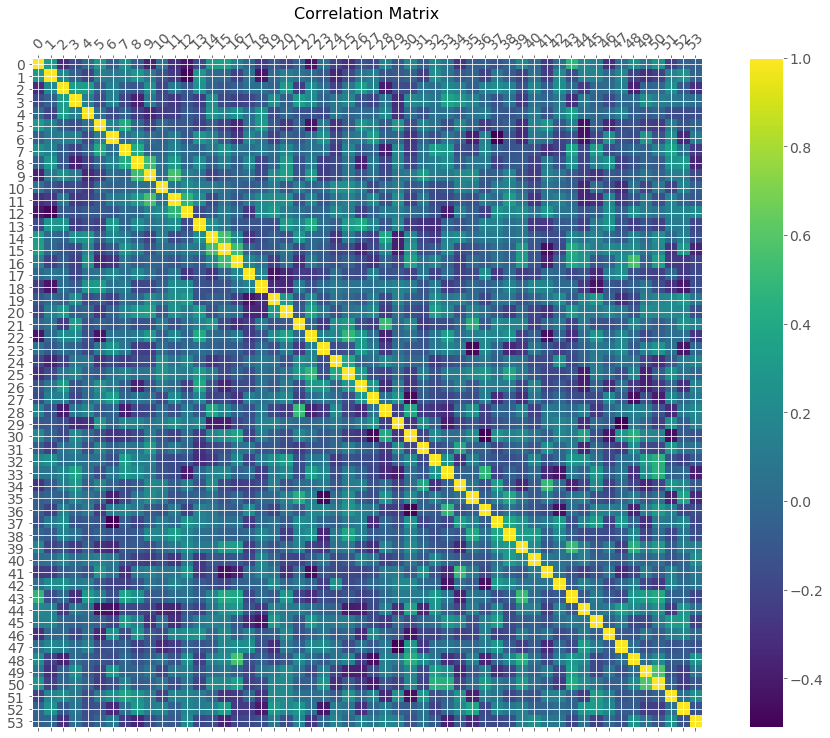

In [123]:
# plt.matshow(df)
# plt.show()

f = plt.figure(figsize=(17, 12))
plt.matshow(df, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Compare correlation matrices
The next step is to compare these correlation matrices, e.g. between the different repetitions of one virtual day or also between two virtual days.